<a href="https://colab.research.google.com/github/hderoche/RNN_Bitcoin_Prediction/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tentative de prédiction du Bitcoin par Analyse Technique et Intelligence Artificielle (RNN - LTSM)

Ce Notebook a pour intention d'explorer les possibilités des réseaux de neurones couplés aux indicateurs de l'analyse technique afin de définir une stratégie et de l'automatiser grâce aux bots de trading.

Ces recherches sont développées en plusieures parties : 
1.   Statistiques descriptives
  *   Comprendre le marché volatil Bitcoin
  *   Déduire des statistiques propres à ce marché
2.   Intégration des Indicateurs
  *   Comprendre leur fontionnement et leur pertinence
  *   Déterminer lesquels utiliser pour de l'algotrading
3.   Contruction du modèle RNN
  *   Ajuster les paramètres et les couches du modele TensorFlow-Keras pour le rendre plus performant
  *   Trouver un modele permettant de prédire à h+24 ou d+2
4.   Robot Trading
  *   Mise en place de la stratégie par scoring
  *   Backtesting sur les données historiques
  *   Optimisation de ses paramètres

Les données sont tirées de https://www.cryptodatadownload.com/

Les commentaires sont en français dans le texte, mais par habitudes le nom des variables et les commentaires dans le code sont en anglais.



# Problèmes rencontrés

*   Sur la partie prédictions à plusieurs périodes, il est difficile de trouver un modele permettant une représentation fidèle du cours. Cela parait normal mais le modèle ne peut pas générer des valeurs lui permettant de s'approcher du cours. Plus l'on essaie de prédire loin dans le temps plus les valeurs s'éloignent.


## Importing

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layer
from sklearn.preprocessing import MinMaxScaler

In [184]:
path = '/content/drive/MyDrive/Colab Notebooks/Bitstamp_BTCUSD_d.csv'

data = pd.read_csv(path, header=0, sep=';')
data['diff'] = data['close'] - data['open']
data = data.drop(['date', 'symbol'], axis=1)
data = data[::-1]
data['index'] = np.arange(data.shape[0])
data = data.reset_index(drop=True)
print(data.head())

         unix    open    high     low  ...  Volume BTC  Volume USD   diff  index
0  1417132800  363.59  381.34  360.57  ...  3220878.18     8617.15  12.69      0
1  1417219200  376.42  386.60  372.25  ...  2746157.05     7245.19   0.30      1
2  1417305600  376.57  381.99  373.32  ...  1145566.61     3046.33  -3.23      2
3  1417392000  376.40  382.31  373.03  ...  2520662.37     6660.56   1.99      3
4  1417478400  378.39  382.86  375.23  ...  2593576.46     6832.53   0.86      4

[5 rows x 9 columns]


## Statistiques Descriptives sur le Bitcoin

### Volatilité et Volume (Correlation)

In [185]:
def volatility_max():
  data['vol'] = data['high'].sub(data['low'], axis=0)
  print(data.head())
volatility_max()

         unix    open    high     low  ...  Volume USD   diff  index    vol
0  1417132800  363.59  381.34  360.57  ...     8617.15  12.69      0  20.77
1  1417219200  376.42  386.60  372.25  ...     7245.19   0.30      1  14.35
2  1417305600  376.57  381.99  373.32  ...     3046.33  -3.23      2   8.67
3  1417392000  376.40  382.31  373.03  ...     6660.56   1.99      3   9.28
4  1417478400  378.39  382.86  375.23  ...     6832.53   0.86      4   7.63

[5 rows x 10 columns]


On calcule la volatilité comme la différence entre le point le plus haut et le point le plus bas de la même période

Ensuite, je normalise les valeurs pour permettre de rendre les calculs plus rapides.

In [186]:
# Pre-processing for display
def normalize(df):
    result = df.copy()
    for feature_name in result.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

dataN = normalize(data)
dfCorrelationN = pd.DataFrame()
dfCorrelationN['volumeBTC'] = dataN['Volume BTC']
dfCorrelationN['volatility'] = dataN['vol']
print(dfCorrelationN.head())
print(dfCorrelationN.corr())
corr_volBTC_vol = dfCorrelationN.corr()['volatility'][0]

   volumeBTC  volatility
0   0.004170    0.004480
1   0.003556    0.003096
2   0.001483    0.001870
3   0.003264    0.002002
4   0.003358    0.001646
            volumeBTC  volatility
volumeBTC    1.000000    0.612587
volatility   0.612587    1.000000


On obtient une corrélation entre la volatilité et le volume de **0.61** soit **61%**

Cela veut dire que lorsque la volatilité augmente, dans 61% du temps cela résulte d'un plus grand volume.

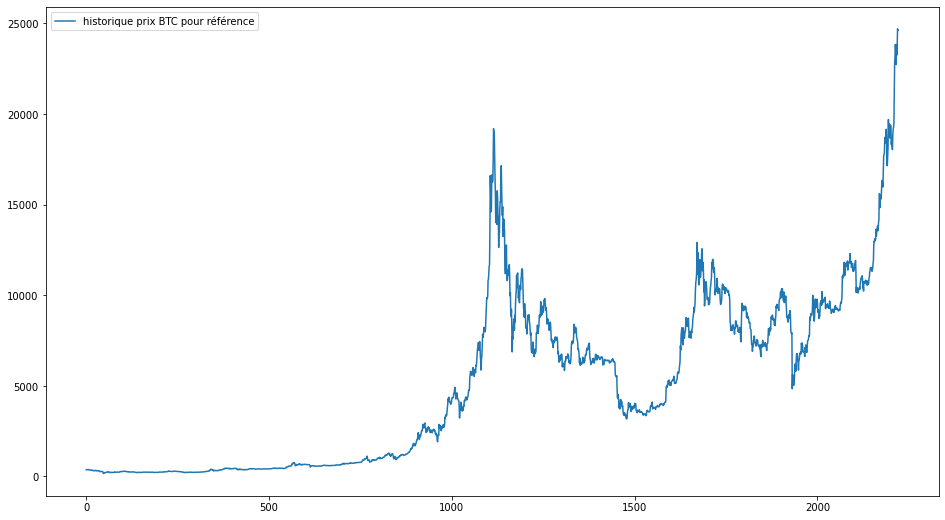

In [187]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['close'], label='historique prix BTC pour référence')
plt.legend()


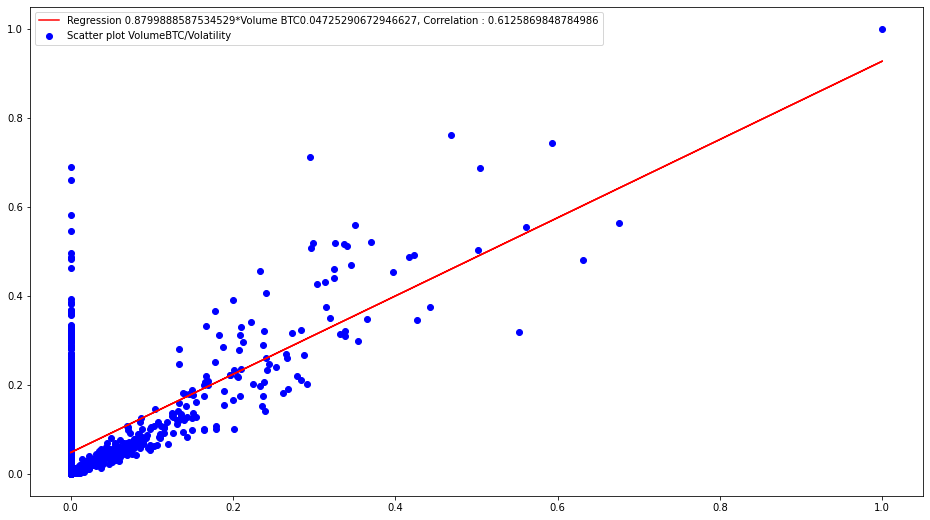

In [188]:
plt.figure(figsize=[16,9])
plt.scatter(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], color='blue', 
         label='Scatter plot VolumeBTC/Volatility')

# Droite de régression
m, b = np.polyfit(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], 1)

plt.plot(dfCorrelationN['volumeBTC'], m*dfCorrelationN['volumeBTC'] + b, color='red', 
         label='Regression ' + str(m) + '*Volume BTC'+ str(b) + ', Correlation : ' + str(corr_volBTC_vol))
plt.legend()
plt.show()

On peut voir la correlation entre le volume et la volatilité



       unix      open      high  ...      diff     index       vol
0  0.000000  0.008211  0.006860  ...  0.513422  0.000000  0.004480
1  0.000450  0.008733  0.007074  ...  0.511388  0.000450  0.003096
2  0.000901  0.008739  0.006886  ...  0.510808  0.000901  0.001870
3  0.001351  0.008732  0.006899  ...  0.511665  0.001351  0.002002
4  0.001802  0.008814  0.006921  ...  0.511480  0.001802  0.001646

[5 rows x 10 columns]
   level_0      unix      open  ...      diff     index       vol
0     2220  1.000000  1.000000  ...  0.495046  1.000000  0.051019
1     2219  0.999550  0.960623  ...  0.668606  0.999550  0.296220
2     2218  0.999099  0.938946  ...  0.595277  0.999099  0.232768
3     2217  0.998649  0.963550  ...  0.417535  0.998649  0.317533
4     2216  0.998198  0.920009  ...  0.689472  0.998198  0.314866

[5 rows x 11 columns]


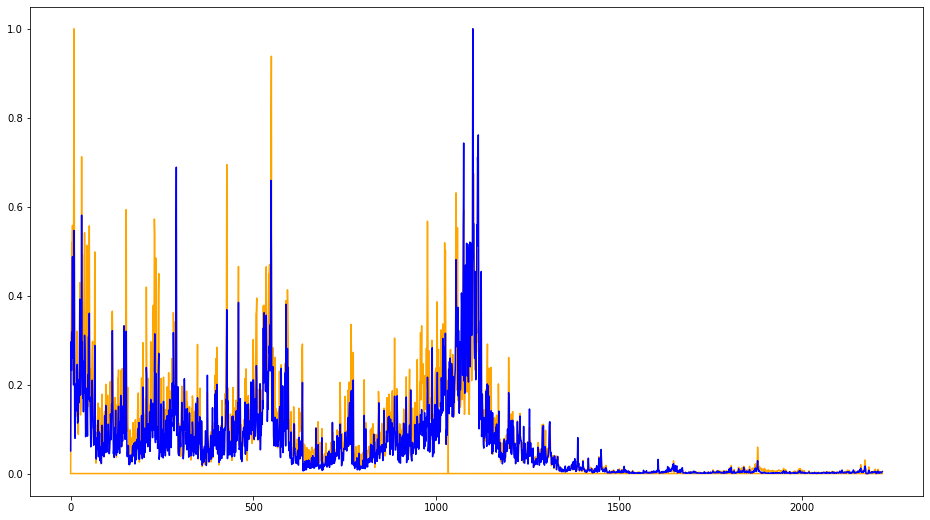

In [189]:
# removing noisy data

print(dataN.head())
dataN = dataN[::-1].reset_index()
print(dataN.head())
plt.figure(figsize=[16,9])
plt.plot(dataN['Volume BTC'], color='orange')
plt.plot(dataN['Volume USD'], color='orange')
plt.plot(dataN['vol'], color='blue')
plt.plot()
plt.show()

### Moyenne des pourcentages volatilité

In [190]:
data['diff'] = data['close'] - data['open']
print(data.head())
data['per'] = ( data['diff']*100 )/data['open']

meanVolatilityPercentage = data['per'].mean()
minVolatilityPercentage = data['per'].min()
maxVolatilityPercentage = data['per'].max()
print('mean',meanVolatilityPercentage)
print('max',maxVolatilityPercentage)
print('min',minVolatilityPercentage)

         unix    open    high     low  ...  Volume USD   diff  index    vol
0  1417132800  363.59  381.34  360.57  ...     8617.15  12.69      0  20.77
1  1417219200  376.42  386.60  372.25  ...     7245.19   0.30      1  14.35
2  1417305600  376.57  381.99  373.32  ...     3046.33  -3.23      2   8.67
3  1417392000  376.40  382.31  373.03  ...     6660.56   1.99      3   9.28
4  1417478400  378.39  382.86  375.23  ...     6832.53   0.86      4   7.63

[5 rows x 10 columns]
mean 0.26124685072043163
max 28.895061728395063
min -39.14663744031452


*   La moyenne de volatilité est de **0.26%**
*   Le max de volatilité est de **28.9%**
*   Le min de volatilité est de **-39.1%**




### Jour Up Down Neutre



In [191]:
def count_up_down_period(data):
  up_days = 0
  down_days = 0
  neutral_days = 0
  for i in range(data.shape[0]):
    if data['diff'][i] > 0:
      up_days+=1
    elif data['diff'][i] < 0:
      down_days+=1
    elif data['diff'][i] == 0:
      neutral_days+=1
  return up_days, down_days, neutral_days

In [192]:
up, down, neutral = count_up_down_period(data)
print('number of up days : ',up)
print('number of down days : ',down)
print('number of neutral days : ',neutral)

number of up days :  1198
number of down days :  1012
number of neutral days :  11


### Statistiques par année

In [193]:
def stats(data):
  mean.append(data['close'].mean())
  max.append(data['close'].max())
  min.append(data['close'].min())
  data['diff'] = data['close'] - data['open']
  data['per'] = ( data['diff']*100 )/data['open']
  vol.append(data['per'].mean())
  volumeBTC.append(data['Volume BTC'].mean())
  volumeUSD.append(data['Volume USD'].mean())

In [194]:
year_data = data.copy()
year_data['date'] = pd.to_datetime(year_data['unix'], unit='s')
year_data['year'] = year_data['date'].dt.year

unique_year = year_data['year'].drop_duplicates()
year_data = year_data.drop(['unix', 'date'], axis=1)

max = []
min = []
mean = []
vol = []
volumeUSD = []
volumeBTC = []
years = ['all history']

stats(year_data)
# Iteration sur chaque année
for year in unique_year:
  # selection des données
  mask = year_data['year'] == year
  strY = str(year)
  temp_data = year_data.loc[mask]
  temp_data = temp_data.reset_index()
  years.append(year)

  ## Stats
  stats(temp_data)


# Ajout des données dans le dataframe Pandas
df_year = pd.DataFrame(years)
df_year = df_year.set_index([0])
df_year['min'] = min
df_year['moyenne'] = mean
df_year['max'] = max
df_year['vol moyenne'] = vol
df_year['Volume BTC'] = volumeBTC
df_year['Volume USD'] = volumeUSD


print(df_year.to_string())

                 min       moyenne       max  vol moyenne    Volume BTC    Volume USD
0                                                                                    
all history   162.00   5011.061396  24705.15     0.261247  1.587456e+07  3.369355e+07
2014          311.94    344.781176    379.25    -0.381627  2.844332e+06  8.341504e+03
2015          162.00    272.140110    463.61     0.119211  4.032125e+06  1.436841e+04
2016          367.64    566.694317    975.97     0.250185  2.979942e+06  5.329448e+03
2017          788.81   3972.231096  19187.78     0.859005  5.930721e+07  1.281281e+04
2018         3179.54   7522.233863  17149.67    -0.258512  2.998677e+07  5.437589e+07
2019         3359.33   7363.344055  12920.54     0.241781  8.204384e+03  6.363052e+07
2020         4841.67  10880.895429  24705.15     0.417437  8.351459e+03  8.794705e+07


Statistiques par année du bitcoin

On remarque que les années de bull run (2017, fin 2020), la volatilité moyenne du bitcoin est plus haute que la moyenne

Et les années de Bear Market (2014,2018) ont des volatilités négatives

En regardant de plus près, on peut voir que la moyenne exponentielle Fibonnacci colle bien la courbe des prix et rebondit lorque le cours se rapproche de celle ci.

## Indicateurs

#### RSI

In [195]:
# RSI integration to the dataset
param = 14
def RSI(data, param): 
    dataLength = len(data)
    priceUp = []  
    priceDown = []
    k = 0
    while k < dataLength:
        if k == 0:
            priceUp.append(0)
            priceDown.append(0)
        else:
            diff = data['close'][k] - data['close'][k-1]
            if diff > 0:
                priceUp.append(diff)
                priceDown.append(0)
            elif diff <= 0:
                priceDown.append(diff)
                priceUp.append(0)
        k+=1
    avgGain = []
    avgLoss = []
    i = 0
    while i < dataLength:
        if i < param + 1:
            avgGain.append(0)
            avgLoss.append(0)
        else:
            avgGain.append(sum([priceUp[i-l] for l in range(0, param + 1)]) / param)
            avgLoss.append(np.abs(sum([priceDown[i-l] for l in range(0, param + 1)]) / param))
        i += 1
    RS = []
    RSI = []
    m = 0
    while m < dataLength:
        if avgGain[m] == 0 and avgLoss[m] == 0:
            RS_TempValue = 0
        else: 
            RS_TempValue = avgGain[m]/avgLoss[m]
        RS.append(RS_TempValue)
        RSI_TempValue = 100 - (100 / (1 + RS_TempValue))
        RSI.append(RSI_TempValue)
        m += 1
    data['RSI'] = RSI
    return data

data = RSI(data, param)

#### MA

In [196]:
def moving_average(data, param):
  data['MA' + str(param)] = data.iloc[:,3].rolling(window=param).mean().fillna(0)
  return data

data = moving_average(data, 200)

#### FMA (Fibonacci Moving Average)

In [197]:
def fibonacci(n):
  if n <= 1:
      return n
  else:
      return fibonacci(n-1) + fibonacci(n-2)

def FMA(n):
  fibo = []
  [fibo.append(fibonacci(i)) for i in range(3, n + 3)]
  print(fibo)
  temp_df = pd.DataFrame()
  temp_df['FMA'] = np.zeros(data.shape[0])
  for coeff in fibo:
    temp_df['FMA'] = temp_df['FMA'] + data.iloc[:, 3].ewm(span=param).mean()
  temp_df['FMA'] = temp_df['FMA']/len(fibo)
  print(temp_df)
  data['FMA'] = temp_df['FMA']
  return data

data = FMA(12)
print(data.tail())

[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
               FMA
0       360.570000
1       366.827143
2       369.307436
3       370.446274
4       371.694340
...            ...
2216  20672.072778
2217  20932.452407
2218  21168.138753
2219  21466.229586
2220  21875.036308

[2221 rows x 1 columns]
            unix      open      high  ...        RSI        MA200           FMA
2216  1608595200  22750.07  23843.21  ...  74.201168  12289.09105  20672.072778
2217  1608681600  23819.08  24096.90  ...  76.338762  12354.58685  20932.452407
2218  1608768000  23215.00  23779.14  ...  76.926274  12421.30735  21168.138753
2219  1608854400  23747.22  24777.00  ...  81.419177  12490.10145  21466.229586
2220  1608940800  24714.01  24768.79  ...  82.380753  12564.92880  21875.036308

[5 rows x 14 columns]


#### Exponential Moving Average

In [198]:
def exponential_moving_average(data, param):
  data['EMA' + str(param)] = data.iloc[:, 3].ewm(span=param).mean()
  data = data[::-1]
  return data


Moving Average on Volume

In [199]:
def moving_average_on_volume(data, param, typeVol):
  data['VOL_MA' + str(param) + str(typeVol)] = data['Volume ' + str(typeVol)].rolling(window=param).mean()
  data = data[::-1]
  return data

#### Visualisation

In [200]:
moving_average(data, 200)
moving_average_on_volume(data, 21, 'USD')
moving_average_on_volume(data, 21, 'BTC')
exponential_moving_average(data, 13)['EMA13']

2220    22012.881414
2219    21592.981650
2218    21291.175258
2217    21056.354468
2216    20794.926880
            ...     
4         371.752870
3         370.493656
2         369.351969
1         366.859231
0         360.570000
Name: EMA13, Length: 2221, dtype: float64

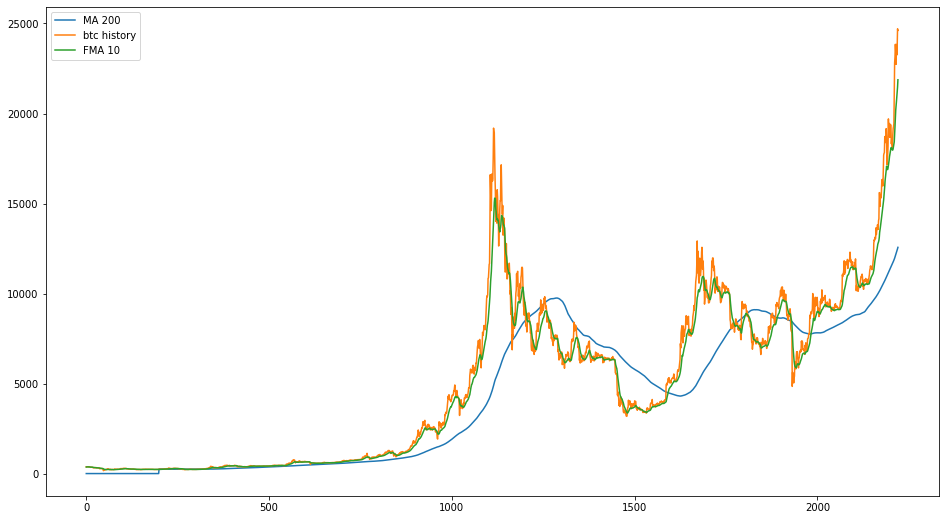

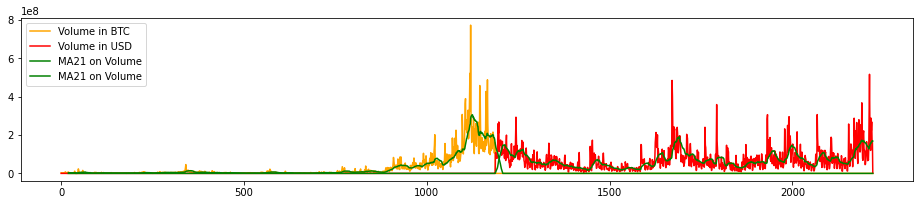

In [201]:
dataTemp = data.reset_index()
plt.figure(figsize=[16, 9])
plt.plot(data['MA200'], label='MA 200')
plt.plot(data['close'], label='btc history')
plt.plot(data['FMA'], label='FMA 10')
plt.legend()
plt.figure(figsize=[16,3])
plt.plot(dataTemp['Volume BTC'], color="orange", scaley='log', label="Volume in BTC")
plt.plot(dataTemp['Volume USD'], color="red", scaley='log', label="Volume in USD")
plt.plot(dataTemp['VOL_MA21USD'], color='green', scaley='log', label="MA21 on Volume")
plt.plot(dataTemp['VOL_MA21BTC'], color='green', scaley='log', label="MA21 on Volume")
plt.legend()
plt.show()

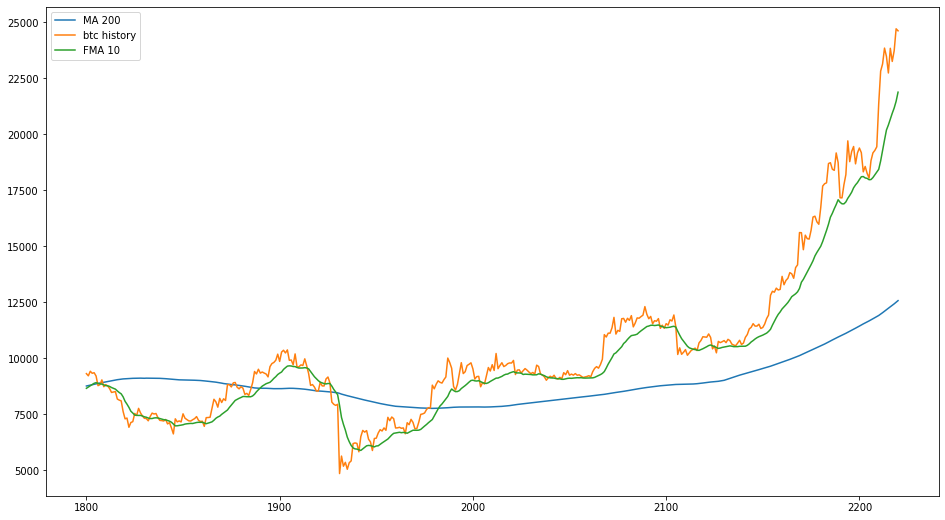

In [202]:
sm_data = data.copy()
sm_data = sm_data[1800:]

plt.figure(figsize=[16, 9])
plt.plot(sm_data['MA200'], label='MA 200')
plt.plot(sm_data['close'], label='btc history')
plt.plot(sm_data['FMA'], label='FMA 10')
plt.legend()
plt.show()

On remarque que les données au niveau des volumes ne sont pas très fiables. On observe que le volume d'échange au niveau des BTC était plus grand avant la bulle de 2017. Depuis, c'est le volume USD qui prédomine, cela s'explique par la valeur du Bitcoin qui augmente.

On a besoin de moins de Bitcoin pour un même montant


---



Sur ces graphiques on peut voir que les moyennes mobiles permettent éventuellement d'avoir de l'information sur un changement de tendance.

Si la moyenne mobile se trouve au dessus du cours alors la tendance est à la vente

Dans le cas contraire, la tendance est à l'achat.

En se basant sur ces informations on peut par exemple scorer avec des règles préécrites pour que le robot puisse soit acheter soit vendre si un nombre suffisant de règles sont validées

## AI Model

### Data Selection

Splitting the data into two parts

1.   Training data
2.   Testing data

The split_index is the percentage of the training data over the testing data


In [203]:
# In percentage
split_index = 70
data_AI = data.copy()
data_AI = data_AI.drop(columns=['index', 'Volume USD', 'unix'])
index = int(np.floor(abs(data_AI.shape[0] * split_index/100)))

data_train, data_test = data_AI.loc[:index, :], data_AI.loc[index + 1:, :]

print(data_train.shape)
print(data_test.shape)


(1555, 14)
(666, 14)


In [204]:
scaler = MinMaxScaler(feature_range=(0,1))
data_training, data_testing = scaler.fit_transform(data_train), scaler.fit_transform(data_test)
L_min = [np.min(data_test.iloc[:,0])]
L_min.append(np.min(data_test.iloc[:,1]))
L_min.append(np.min(data_test.iloc[:,2]))
L_min.append(np.min(data_test.iloc[:,3]))
L_min.append(np.min(data_test.iloc[:,4]))
L_min.append(np.min(data_test.iloc[:,5]))

## Getting the data for the train and test part
x_train = []
y_train = []

def data_selection(data_to_select):
    X = []
    y = []
    for i in range(data_to_select.shape[0] - 60):
        subset = []
        y.append(data_to_select[i + 60, :])
        for j in range(60):
            subset.append(data_to_select[i + j])
        X.append(subset)
    X,y = np.array(X),np.array(y)

    return X, y

x_test = []
y_test = []
x_train = []
y_train = []

for i in range(60, data_train.shape[0] - 1):
    x_train.append(data_training[i - 60:i])
    y_train.append(data_training[i + 1, :])

for i in range(60, data_test.shape[0] - 1):
    x_test.append(data_testing[i-60:i])
    y_test.append(data_testing[i + 1, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape)
print(x_train.shape)

(605, 60, 14)
(1494, 60, 14)


### Contruction du modele

In [205]:
def AI_model():
    model = tf.keras.Sequential()

    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(layer.Dropout(0.4))
    model.add(layer.LSTM(units = 600, activation=tf.nn.relu, return_sequences=True))
    model.add(layer.Dropout(0.2))
    model.add(layer.LSTM(units=600, activation=tf.nn.relu))
    model.add(layer.Dropout(0.2))
    model.add(layer.Dense(60))
    model.add(layer.Dense(6))


    # As this is a regression model, we want to calulate the price of the asset for the next day, we use the mean sqaured error as a loss funtion.
    # The adam optimizer is the standard in the AI libraries.
    model.compile(optimizer='adam',
                  loss = 'mean_squared_error')

     # Show how the RNN is structured and how many parameters there is.
    print(model.summary())

    # Fitting the model to the train dataset
    # Changing the epoch number will decrease the render time

    model.fit(x_train, y_train, epochs=10, batch_size=32)


    # Saving the model
    model.save('/content/drive/MyDrive/Colab Notebooks/btcAI')

In [206]:
#AI_model()

#### Modele \#1 Prédiction de la valeur suivante

Ce modele permet de prévoir la valeur de la période suivante, et ainsi d'avoir la bonne direction (achat/vente)

In [207]:
# Loading the model from the file in the same repository
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/btcAI')
#print(X_test[:6])
print(x_test.shape)
# Getting the results on the test dataset
y_preds = new_model.predict(x_test, use_multiprocessing=True)

#first_y = new_model.predict(X_test)
#print(first_y)


# Unscaling the data, in order to have the real results
# This step can be a source of error because we might loose some information by unscaling the data and deforming it
for i in range(y_test.shape[1]):
  scale = scaler.scale_[i]
  y_test[:, i] = y_test[:, i]/scale + L_min[i]
  y_preds[:, i] = y_preds[:, i]/scale + L_min[i]

# Printing the latest value for the predicted value and the real value
print("Last real value : ", y_test[-1])
print("Last predicted value : ",y_preds[-1])


(605, 60, 14)


ValueError: ignored

In [ ]:
plt.figure(figsize=[16, 9])
plt.plot(y_test[:,3])
plt.plot(y_preds[:, 3])
plt.show()

In [ ]:
## Difference

print(len(y_preds))
print(len(y_test))
diff_test = []
diff_test_preds = []
for i in range(1,len(y_test)):
  temp_diff = y_test[i, 3] - y_test[i-1, 3]
  temp_diff_preds = y_preds[i, 3] - y_preds[i-1, 3]
  if temp_diff >= 0:
    diff_test.append(1)
    diff_test_preds.append(1)
  elif temp_diff < 0:
    diff_test.append(0)
    diff_test_preds.append(0)

score = 0
for i in range(len(diff_test)):
  if diff_test[i] == diff_test_preds[i]:
    score += 1
if score == len(diff_test):
  print('all good')
print(score)
    

#### Modele \#2 Prédiction à plusieurs périodes

Ici le meme modele est appliqué, cependant il ne se sert que des 60 premières valeurs, ensuite l'algorithme utilise ses prédictions pour faire les prédictions suivantes.

Ce modele est beaucoup moins précis mais a le mérite de se servir de ses propres résultats pour continuer à prédire.

In [ ]:

# for i in range(60, data_test.shape[0] - 1):
#     x_test.append(data_testing[i-60:i])

def select(data, i):
  return data[i - 60:i]

def prediction():
  
  all_pred = x_test.copy()
  all_data_test = data_testing.copy()
  print(all_pred.shape[0])
  
  for i in range(60, all_pred.shape[0] - 1):
    all_pred[i] = select(all_data_test, i)
    all_pred[i+1] = select(all_data_test, i+1)
    next_pred = new_model.predict(all_pred[i:i+1, :])
    #print(i, next_pred[0])
    if i + 60 + 2 >= all_pred.shape[0]: 
     # print('append',i)
      np.append(all_data_test, next_pred[0])
    else:

      all_data_test[i + 2] = next_pred[0]
  return all_data_test


predictions = prediction()


In [ ]:
for i in range(predictions.shape[1]):

  scale = scaler.scale_[i]
  predictions[:, i] = predictions[:, i]/scale + L_min[i]


print(x_test.shape)

In [ ]:
print(predictions.shape)
print(y_test.shape)
plt.figure(figsize=[16, 9])
plt.plot(y_test[:, 3])
plt.plot(predictions[:, 3])
plt.show()

#### Modele \#3 Essai en modifiant la façon dont le modele utilise ses propres données

In [ ]:

# for i in range(60, data_test.shape[0] - 1):
#     x_test.append(data_testing[i-60:i])

def select(data, i):
  return data[i - 60:i]

def prediction():
  
  all_pred = x_test.copy()
  all_pred = all_pred[:100]
  all_data_test = data_testing.copy()
  all_data_test = all_data_test[:100]
  print(all_pred.shape[0])
  
  for i in range( 60, all_pred.shape[0] - 1):
    all_pred[i-60] = select(all_data_test, i)
    all_pred[i + 1 - 60] = select(all_data_test, i+1)
    next_pred = new_model.predict(all_pred[i-60:i - 60 +1, :])
    #print(i, next_pred[0])
    if i + 2 >= all_pred.shape[0]: 
     # print('append',i)
      np.append(all_data_test, next_pred[0])
    else:
      all_data_test[i + 2] = next_pred[0]
  return all_data_test


predictions = prediction()
predictions[:, 3] = predictions[:, i]/scaler.scale_[3] + L_min[3]
print(L_min[3])
print(scaler.scale_[3] )


In [ ]:
plt.figure(figsize=[16, 9])
plt.plot(y_test[:100, 3])
plt.plot(predictions[:, 3])
plt.plot(y_preds[:100, 3])
plt.show()

## Bot

Ici je créé le bot pour pouvoir récupérer les stats des trades, et permettre de simplifier le code.

Il sera alors possible d'instancier un nouveau bot pour une autre paire d'actif.

In [ ]:
class Bot():
  def __init__(self):
    self.nb_trade = 0
    self.nb_long = 0
    self.nb_short = 0
    self.open_position = 0
    self.price_on_entry = -1
    self.time_on_entry = -1
    self.roe = []
    self.delta = []
    self.trade = []

  def entry(self):
    return self.price_on_entry
  
  def long(self, data):
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_long += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'

  def short(self, data):
    if self.on_position() == False:
      self.nb_trade += 1
      self.nb_short += 1
      self.open_position += 1
      self.price_on_entry = data['open']
      self.time_on_entry = data['index']
    else:
      return 'Already on position'
  
  def close_long(self, data):
    if self.on_position() == True :
      self.open_position -= 1
      diff = data['open'] - self.price_on_entry
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'long', diff, ROE, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
    else:
      return 'Not on position'
  
  def close_short(self, data):
    if self.on_position() == True:
      self.open_position -= 1
      diff = self.price_on_entry - data['open']
      self.delta.append(diff)
      ROE = (diff/self.price_on_entry)*100
      self.roe.append(ROE)
      t = Trade(self.nb_trade, 'short',diff, ROE, self.price_on_entry, data['open'], self.time_on_entry, data['index'])
      self.trade.append(t)
    else:
      return 'Not on position'
  
  def on_position(self):
    if self.open_position != 0:
      return True
    else:
      return False

  def add_trade(self, i):
    t = Trade(i, 100, 10)
    self.trade.append(t)

  def on_profit(self):
    if len(self.roe) > 0 and self.nb_trade > 0:
      mean_roe = sum(self.roe) / len(self.roe)
      if mean_roe > 0:
        return True, mean_roe
      else:
          return False, mean_roe
    else:
      print('No trade yet')
      return
  
  def show_trades(self):
    df_trade = pd.DataFrame.from_records([trade.to_dict() for trade in self.trade])
    return df_trade

  def reset_bot(self):
    self.nb_trade = 0
    self.nb_long = 0
    self.nb_short = 0
    self.open_position = 0
    self.price_on_entry = -1
    self.time_on_entry = -1
    self.roe = []
    self.delta = []
    self.trade = []

class Trade():
  def __init__(self, nb_trade, trade, delta, roe, entry_price, closing_price, date_entry, date_close):
    self.nb_trade = nb_trade
    self.trade = trade
    self.delta = delta
    self.roe = roe
    self.entry_price = entry_price
    self.closing_price = closing_price
    self.date_entry = date_entry  
    self.date_close = date_close  
  def to_string(self):
    print('Trade #' + str(self.nb_trade) + ' - Delta : ' + str(self.delta) + ' - PNL : ' + str(self.roe))
  
  def to_dict(self):
    return {
        '#': self.nb_trade,
        'trade': self.trade,
        'Delta': self.delta,
        'PNL': self.roe,
        'Entry': self.entry_price,
        'Close': self.closing_price, 
        'Entry date': self.date_entry,
        'Close date': self.date_close
    }

### Defining the scoring system


Le bot de trading déterminera les ordres d'achat ou de vente si les conditions suivantes sont validées. La méthode de scoring permet de mettre une stratégie en place dès qu'un nombre définit de condition sont réunis

*   MA200 (donne la tendance générale du mouvement)
  *   Au dessus du cours -> Achat +1
  *   En dessous -> Vente -1
*   RSI
  *   Si en survente -> Achat +1
  *   En surachat -> Vente -1
*   Prédiction AI model
  * Si 1 -> +2
  * Si 0 -> -2
*   FMA - Si data[open] - FMA < epsilon
    * Si positif -> Achat +1
    * Si négatif -> Vente -1

In [ ]:
# Initialisation du Bot
btcBot = Bot()

In [ ]:
# Data à instant t
def rules(data):
  score = 0
  if data['open'] > data['MA200'] :
    score += 2
  if data['open'] < data['MA200']:
    score -= 2
  if data['RSI'] > 70:
    score -= 1
  if data['RSI'] < 65:
    score += 1
  # if data['pred'] == 1:
  #   score += 2
  # if data['pred'] == 0:
  #   score -= 2
  return score

def decision(score, data, threshold, target, risk):
  
  position = 0
  for i in range(data.shape[0]):
    _score = score[i]
    _data = data.iloc[i, :]
    onPos = btcBot.on_position()
    if onPos == False :
      if _score >= threshold:
        btcBot.long(_data)
        position = 1
      if _score <= - threshold:
        btcBot.short(_data)
        position = -1
    elif onPos == True:
      delta = _data['open'] - btcBot.entry()
      pnl = (delta / btcBot.entry())*100
      # si le trade est perdant -> cloturer la position
      if pnl < - risk and position == 1 or pnl > target:
        btcBot.close_long(_data)
      elif pnl > risk and position == -1 or pnl < -target:
        btcBot.close_short(_data)
      # si le trade est gagnant -> on laisse courir
      # plus tard eventuellement ajouter les take-profit partiels pour assurer le BE ou un minimum de gain



### BackTesting

In [ ]:
def scoring():
  L_score = []
  for i in range(data.shape[0]):
    L_score.append(rules(data.iloc[i, :]))
  return L_score

scoring()

decision(scoring(), data, 2, 40, 10)
btcBot.show_trades()

In [ ]:
def optimize():
  L_score = scoring()
  for i in range(0, 2 + 1):
    threshold = i
    print('threshold', threshold)
    for j in range(1, 40 + 1):
      target = j
      print('target', target)
      for k in range(1, 10 + 1):
        risk = k
        decision(L_score, data, threshold, target, risk)
        temp_res = 0
        temp_var = [0, 0, 0]
        onProfit, meanPNL = btcBot.on_profit()
        if meanPNL > temp_res:
          temp_res = meanPNL
          temp_var = [threshold, target, risk]
        btcBot.reset_bot()
  return temp_res, temp_var
# Result Threshold: 2, Target: 40, Risk: 10
# Mean PNL : 5.2980928157229
#optimize()

In [ ]:

print(btcBot.on_profit())
df_trade = btcBot.show_trades()
print('number of long open :', btcBot.nb_long)
print('number of short open :', btcBot.nb_short)
print(df_trade)

In [ ]:
plt.figure(figsize=[16, 9])
plt.scatter(df_trade['Entry date'], df_trade['Entry'], color='green', label='Entry')
plt.scatter(df_trade['Close date'], df_trade['Close'], color='red', label='Close')
plt.plot(data['open'], color='blue', label='Bitcoin price')
plt.legend()
plt.show()